In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta
from optim import *

In [9]:
cutoff_date = date.today() - relativedelta(years = 2)
cutoff_date

datetime.date(2023, 4, 30)

In [5]:
pd.read_excel("portfolioTickers.xlsx")

,highCorrelationPortfolio,mixedCorrelationPortfolio,lowCorrelationPortfolio
0,AEE,PNW,ABT
1,AEP,TKO,AIG
2,CMS,AEP,AKAM
3,D,DUK,AXON
4,DTE,SO,CAG
5,DUK,CNC,CTRA
6,ED,DVA,DECK
7,ES,ED,DLTR
8,EVRG,WEC,MNST
9,LNT,AEE,MOH


Downloading historical prices

In [6]:
tickers = list(pd.read_excel("portfolioTickers.xlsx")["highCorrelationPortfolio"])
prices = yf.download(tickers, period = '10y' , progress = False)['Close'].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-04-30,30.227377,39.785175,25.141291,46.859947,48.557438,51.043728,42.686893,34.915634,26.320280,22.148626
2015-05-01,30.419350,39.897114,25.378399,46.873024,48.831833,51.260880,42.763172,35.008728,26.369219,22.346415
2015-05-04,30.707304,40.127972,25.459908,46.912266,49.155014,51.300343,43.068329,35.345280,26.585930,22.661402
2015-05-05,29.968967,39.106583,24.896767,46.297729,47.984226,50.175110,42.180603,34.528957,25.893839,22.137634
2015-05-06,29.806536,38.817017,24.784645,46.225830,47.532993,50.280411,42.374809,34.213886,25.306612,22.046061
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,98.629997,107.019997,73.500000,53.330002,136.160004,121.419998,112.519997,57.959999,68.110001,61.230000
2025-04-24,98.919998,106.699997,74.139999,53.349998,136.979996,120.699997,111.290001,58.529999,68.279999,61.330002
2025-04-25,98.279999,106.739998,72.180000,52.950001,134.759995,119.849998,110.449997,57.860001,67.879997,60.740002


In [7]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [10]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-05-01,0.006351,0.002814,0.009431,0.000279,0.005651,0.004254,0.001787,0.002666,0.001859,0.008930
2015-05-04,0.009466,0.005786,0.003212,0.000837,0.006618,0.000770,0.007136,0.009613,0.008218,0.014096
2015-05-05,-0.024044,-0.025453,-0.022119,-0.013100,-0.023818,-0.021934,-0.020612,-0.023096,-0.026032,-0.023113
2015-05-06,-0.005420,-0.007405,-0.004503,-0.001553,-0.009404,0.002099,0.004604,-0.009125,-0.022678,-0.004137
2015-05-07,0.000743,0.005458,0.000302,0.003111,0.005644,0.005235,0.002291,0.002930,-0.006906,0.001662
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.008448,0.003407,0.010222,-0.003292,0.005717,0.005490,0.008077,0.006342,0.001111,0.004522
2023-04-25,0.000441,0.001486,0.005943,-0.003651,0.004111,0.008493,0.005609,0.002899,0.009352,0.003781
2023-04-26,-0.019502,-0.022568,-0.014530,-0.020764,-0.016026,-0.013936,-0.012550,-0.025889,-0.025911,-0.018834


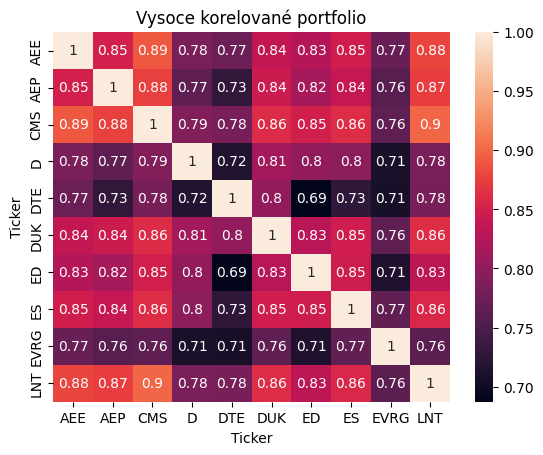

In [12]:
plt.Figure(figsize = (10, 10))
sns.heatmap(returns_train.corr(), annot = True)
plt.title("Vysoce korelované portfolio")
plt.show()

In [26]:
weightsMVOTangent = MVOTangentPortfolio(prices = prices)
weightsPlot(weightsMVOTangent, title = "MVO tangentní portfolio")

Expected annual return: 12.1%
Annual volatility: 20.8%
Sharpe Ratio: 0.58
(np.float64(0.12112744535722944), np.float64(0.20801543452580495), np.float64(0.5823002780219331))


In [27]:
weightsMVOTarget = MVOTargetReturn(prices = prices, target_return = 0.1)
weightsPlot(weightsMVOTarget, title = "MVO optimální portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.3%
Annual volatility: 19.4%
Sharpe Ratio: 0.53
(np.float64(0.10260352607247959), np.float64(0.19382119864248484), np.float64(0.5293720541979421))


In [28]:
weightsLWCorrelationTangent = MVOTangentPortfolio(prices = prices, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTangent, title = "Robustní MVO tangentní portfolio")

Expected annual return: 12.1%
Annual volatility: 20.6%
Sharpe Ratio: 0.59
(np.float64(0.1210321498305731), np.float64(0.20642909460240913), np.float64(0.5863134267177114))


In [29]:
weightsLWCorrelationTarget = MVOTargetReturn(prices = prices, target_return = 0.1, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTarget, title = "Robustní MVO portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 10.3%
Annual volatility: 19.4%
Sharpe Ratio: 0.53
(np.float64(0.10281565886724948), np.float64(0.1935509395127557), np.float64(0.5312072321946728))


In [31]:
weightsCustomDeltaTangent = RobustLedoitWolfCustomDeltaMaxSharpe(prices = prices, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTangent, title = "Robustní tangentní portfolio s deltou 0.5")

Expected annual return: 11.2%
Annual volatility: 15.3%
Sharpe Ratio: 0.73
(np.float64(0.1116929503918796), np.float64(0.1527029157370728), np.float64(0.7314395396627197))


In [32]:
weightsCustomDeltaTarget = RobustLedoitWolfCustomDeltaTargetReturn(prices = prices, target_return = 0.1, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTarget, title = "Robustní portfolio s deltou 0.5 a cílovým výnosem 10% p.a.")

Expected annual return: 10.0%
Annual volatility: 14.8%
Sharpe Ratio: 0.68
(np.float64(0.1), np.float64(0.1478760139764505), np.float64(0.6762421931113531))


In [33]:
weightsMinCVaR = CVaROptimizationMinCVAR(prices= prices, alpha = 0.05)
weightsPlot(weightsMinCVaR, title = "CVaR optimální portfolio")

Expected annual return: 10.0%
Conditional Value at Risk: 2.84%
(np.float64(0.09983499984150816), np.float64(0.028367107371839687))


In [43]:
weightsBLTangent = blackLittermanAbsoluteViewsMaxSharpe(prices = prices, views = {})
weightsPlot(weightsBLTangent, title = "Black-Litterman tangentní portfolio (bez Views)")

Expected annual return: 15.0%
Annual volatility: 19.7%
Sharpe Ratio: 0.77
(np.float64(0.1504083307213758), np.float64(0.1965417519642003), np.float64(0.7652741934892917))


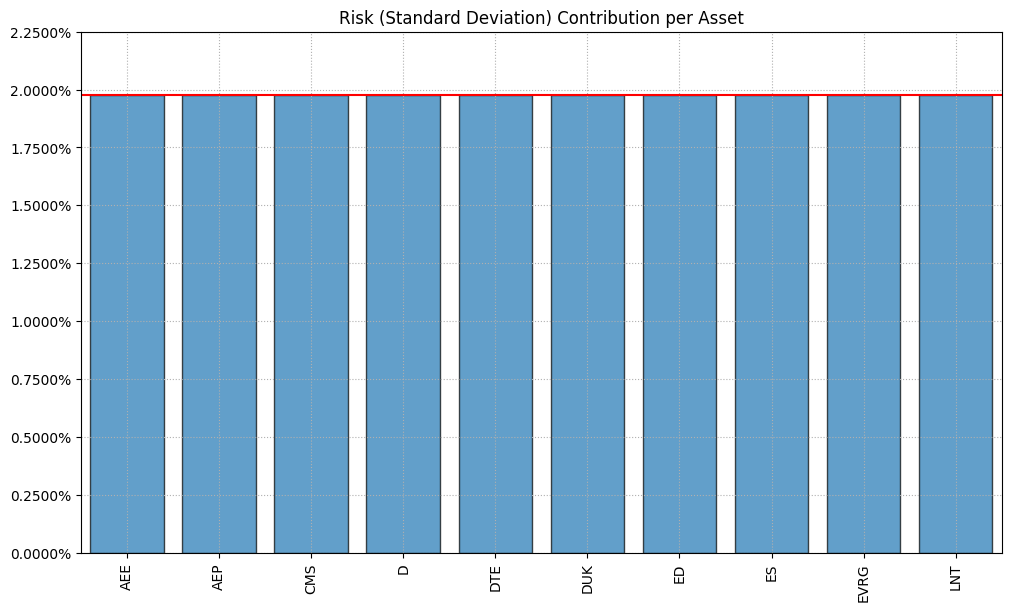

In [42]:
weightsRP_std, rpPlot = riskParityERC(prices = prices)
weightsPlot(weightsRP_std, title = "Rizikově paritní portfolio (směrodatná odchylka)")

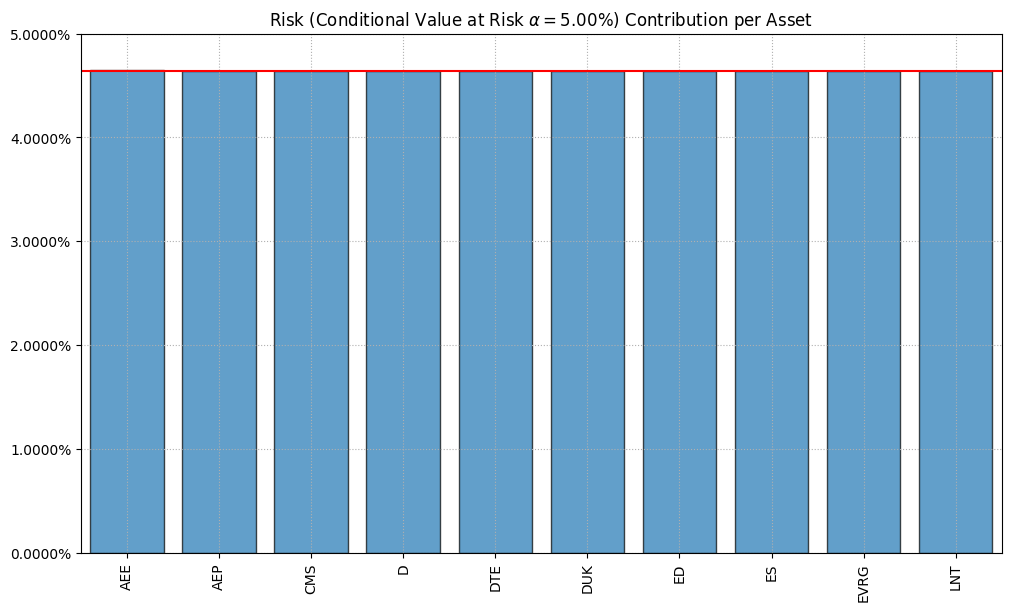

In [44]:
weightsRP_CVaR, rpPlot = riskParityERC(prices = prices, risk_measure = "CVaR")
weightsPlot(weightsRP_CVaR, title = "Rizikově paritní portfolio (CVaR)")

Hierarchical risk parity

In [68]:
in_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [69]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [70]:
in_sample_returns.std().sort_values().map('{:.3%}'.format)

MVO Target 10%              1.259%
LedoitWolf Target 10%       1.265%
MVO Target 10% (d = 0.5)    1.271%
Black-Litterman Tangent     1.272%
CVaR                        1.273%
RP (std)                    1.279%
RP (CVaR)                   1.279%
MVO Tangent (d = 0.5)       1.286%
MVO Tangent                 1.349%
LedoitWolf Tangent          1.350%
dtype: object

In [71]:
in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

MVO Target 10%              -33.679%
Black-Litterman Tangent     -33.406%
CVaR                        -33.239%
MVO Target 10% (d = 0.5)    -33.163%
RP (std)                    -33.096%
RP (CVaR)                   -33.085%
LedoitWolf Target 10%       -32.911%
MVO Tangent (d = 0.5)       -32.125%
MVO Tangent                 -29.927%
LedoitWolf Tangent          -29.341%
dtype: object

In [72]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
in_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman Tangent      9.75%
CVaR                        10.52%
LedoitWolf Target 10%       10.57%
RP (std)                    10.70%
RP (CVaR)                   10.71%
MVO Target 10%              10.84%
MVO Target 10% (d = 0.5)    11.07%
MVO Tangent (d = 0.5)       12.25%
LedoitWolf Tangent          12.96%
MVO Tangent                 13.05%
dtype: object

In [73]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2023-05-02,-0.005802,-0.014787,-0.002434,-0.027836,-0.012040,-0.015037,-0.005448,-0.016470,-0.016488,-0.013565
2023-05-03,-0.005162,-0.004492,-0.004879,0.004142,0.000269,-0.002766,-0.005377,0.002617,0.003906,-0.002017
2023-05-04,0.012408,0.006273,0.009687,0.014527,0.009406,0.008014,0.004896,0.001044,0.008106,0.006798
2023-05-05,0.008022,0.007327,0.011258,-0.001414,0.006035,0.012741,0.009846,0.009385,0.006594,0.005657
2023-05-08,-0.014701,0.000326,-0.012746,0.000177,-0.003176,-0.004630,-0.004825,-0.008910,-0.008628,-0.006351
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,-0.005245,-0.010448,-0.002714,-0.001311,0.002651,-0.009059,-0.006884,-0.001550,-0.003657,0.003277
2025-04-24,0.002940,-0.002990,0.008707,0.000375,0.006022,-0.005930,-0.010931,0.009834,0.002496,0.001633
2025-04-25,-0.006470,0.000375,-0.026436,-0.007498,-0.016207,-0.007042,-0.007548,-0.011447,-0.005858,-0.009620


In [74]:
out_of_sample = {
    'MVO Tangent': (weightsRebalancing(weightsMVOTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10%': (weightsRebalancing(weightsMVOTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Tangent': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'LedoitWolf Target 10%': (weightsRebalancing(weightsLWCorrelationTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Tangent (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO Target 10% (d = 0.5)': (weightsRebalancing(weightsCustomDeltaTarget, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'Black-Litterman Tangent': (weightsRebalancing(weightsBLTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [82]:
out_of_sample_returns.std().sort_values(ascending=False).map('{:.3%}'.format)

MVO Tangent                 1.144%
LedoitWolf Tangent          1.139%
RP (std)                    1.097%
RP (CVaR)                   1.097%
Black-Litterman Tangent     1.091%
MVO Tangent (d = 0.5)       1.078%
MVO Target 10% (d = 0.5)    1.071%
LedoitWolf Target 10%       1.055%
MVO Target 10%              1.055%
CVaR                        1.046%
dtype: object

In [76]:
out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

LedoitWolf Tangent          -19.079%
MVO Tangent                 -18.918%
RP (CVaR)                   -18.567%
RP (std)                    -18.532%
MVO Tangent (d = 0.5)       -17.807%
MVO Target 10% (d = 0.5)    -17.672%
Black-Litterman Tangent     -17.604%
MVO Target 10%              -16.642%
CVaR                        -16.582%
LedoitWolf Target 10%       -16.162%
dtype: object

In [81]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
out_of_sample_cagr.sort_values(ascending=False).map('{:.2%}'.format)

LedoitWolf Target 10%       13.83%
MVO Target 10%              13.64%
CVaR                        13.04%
MVO Tangent (d = 0.5)       12.23%
MVO Target 10% (d = 0.5)    11.90%
Black-Litterman Tangent     11.49%
LedoitWolf Tangent          11.11%
MVO Tangent                 11.08%
RP (std)                    10.20%
RP (CVaR)                   10.19%
dtype: object

In [80]:
(out_of_sample_cagr / (out_of_sample_returns.std() * np.sqrt(252))).sort_values(ascending= False)

LedoitWolf Target 10%       0.825536
MVO Target 10%              0.814255
CVaR                        0.784965
MVO Tangent (d = 0.5)       0.715101
MVO Target 10% (d = 0.5)    0.700049
Black-Litterman Tangent     0.663582
LedoitWolf Tangent          0.614716
MVO Tangent                 0.610405
RP (std)                    0.585611
RP (CVaR)                   0.584934
dtype: float64

In [86]:
anr = pd.DataFrame()

for ticker in tickers:
    rec = pd.read_excel(r"C:\Users\miros\Desktop\masters\BL_Input\AnalystRecommendation.xlsx", sheet_name = ticker)
    rec["Ticker"] = ticker
    anr = pd.concat([anr, rec])

anr

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker
0,2023-04-25,94.230766,90.76,0.533333,0.466667,0.000000,3.470766,AEE
1,2023-05-25,94.230766,80.95,0.533333,0.466667,0.000000,13.280766,AEE
2,2023-06-25,91.857140,80.83,0.600000,0.400000,0.000000,11.027140,AEE
3,2023-07-25,91.923080,88.02,0.600000,0.400000,0.000000,3.903080,AEE
4,2023-08-25,88.666664,80.45,0.562500,0.437500,0.000000,8.216664,AEE
...,...,...,...,...,...,...,...,...
20,2024-12-25,62.576923,59.62,0.285714,0.714286,0.000000,2.956923,LNT
21,2025-01-25,62.500000,58.77,0.285714,0.714286,0.000000,3.730000,LNT
22,2025-02-25,64.038460,63.75,0.285714,0.714286,0.000000,0.288460,LNT
23,2025-03-25,64.708336,62.10,0.285714,0.714286,0.000000,2.608336,LNT


In [91]:
anr.query("Ticker == 'LNT'")

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker
0,2023-04-25,57.799999,55.75,0.333333,0.583333,0.083333,2.049999,LNT
1,2023-05-25,57.700001,51.06,0.333333,0.666667,0.000000,6.640001,LNT
2,2023-06-25,56.500000,51.83,0.384615,0.615385,0.000000,4.670000,LNT
3,2023-07-25,56.681820,55.56,0.461538,0.538462,0.000000,1.121820,LNT
4,2023-08-25,55.545456,50.78,0.461538,0.538462,0.000000,4.765456,LNT
5,2023-09-25,55.083332,51.05,0.500000,0.500000,0.000000,4.033332,LNT
6,2023-10-25,53.458332,49.54,0.571429,0.428571,0.000000,3.918332,LNT
7,2023-11-25,53.541668,49.75,0.571429,0.428571,0.000000,3.791668,LNT
8,2023-12-25,53.708332,50.94,0.571429,0.428571,0.000000,2.768332,LNT
9,2024-01-25,54.500000,48.75,0.428571,0.571429,0.000000,5.750000,LNT
